In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az

sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/tolex3/resources/master/Rethinking_2/Data/Howell1.csv',sep=';')

df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


<AxesSubplot:xlabel='weight', ylabel='height'>

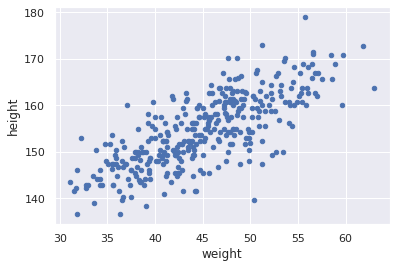

In [3]:
df = df.loc[df['age'] >= 18]
df.plot(x='weight',y='height',kind='scatter',color='b')


In [4]:
x = df['weight'].values
gender_idx = df['male']

model = pm.Model()
with model:
    alpha = pm.Normal('alpha',170,30,shape=2)
    beta = pm.Normal('beta',1,2,shape=2)
    sigma = pm.Uniform('sigma',0,50)
    
    reg = pm.Deterministic('reg',alpha[gender_idx] + beta[gender_idx] * x)
    
    obs = pm.Normal('obs',mu=reg,sd=sigma,observed=df['height'])
    
    trace = pm.sample(500,tune=500)

<ipython-input-4-a91e34a7116f>:14: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(500,tune=500)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 9 seconds.


In [5]:
with model:
    idata = az.from_pymc3(trace,coords={'gender_idx': np.array(['female','male'])}, 
    dims={'alpha': ['gender_idx'], 'beta': ['gender_idx']})
    


In [9]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

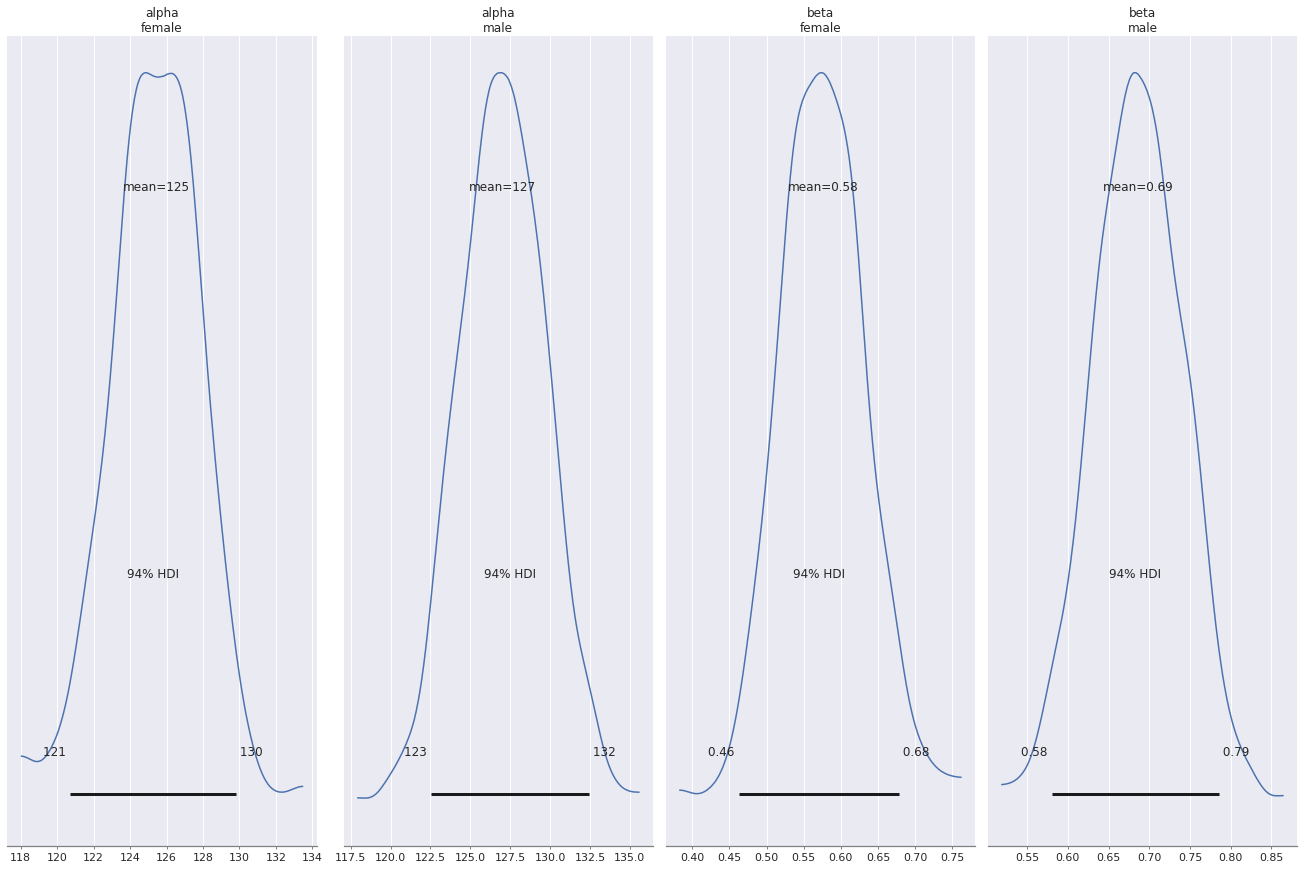

In [6]:
with model:
    _ = az.plot_posterior(idata,var_names=['alpha','beta'],
                          coords={'gender_idx' : ['female','male']},
                         figsize=(18,12))

In [7]:
f_idx = df['male'] == 0
m_idx = df['male'] == 1

x_f = df.loc[df['male'] == 0]['weight']
x_m = df.loc[df['male'] == 1]['weight']

trace_f = trace['reg'][:,f_idx]
trace_m = trace['reg'][:,m_idx]

[[145.79660818 142.73222328 148.97379253 ... 152.79017373 144.3114155
  157.45255076]
 [146.02183103 143.1154344  149.03521158 ... 152.65483438 144.61320935
  157.07683662]
 [146.84076061 144.48662857 149.28154781 ... 152.21338096 145.69980091
  155.79512786]
 ...
 [146.61980471 144.23550862 149.09186629 ... 152.06126571 145.46422562
  155.68890637]
 [146.53511342 144.05670879 149.10474768 ... 152.19134977 145.33392345
  155.96217401]
 [146.30951085 143.55071276 149.16985979 ... 152.60566354 144.97242466
  156.80309867]]


/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/usr/local/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


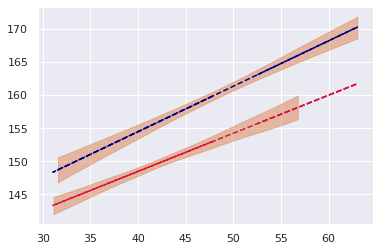

In [8]:


print (trace_f)

plt.plot(x,trace['alpha'][:,0].mean() + x * trace['beta'][:,0].mean(),color='crimson',ls='dashed')
plt.plot(x,trace['alpha'][:,1].mean() + x * trace['beta'][:,1].mean(),color='navy',ls='dashed')

ax = plt.gca()

draws = range(0,len(trace['reg']),10)

#plt.plot(x,trace['alpha'][:,1][draws] + trace['beta'][:,1][draws] * x[:,None],color='lightblue',alpha=0.05)
#plt.plot(x,trace['alpha'][:,0][draws] + trace['beta'][:,0][draws] * x[:,None],color='orange',alpha=0.05)

#### QUESTION : HOW TO DO THE below TWO CI-PLOTS WITH ARVIZ ? 
#### that is, how to make arviz 'aware' which of the items in trace['reg'] belong to the male/female categories ?
#### 

az.plot_hdi(x_f,trace_f,ax=ax)
az.plot_hdi(x_m,trace_m,ax=ax)

### how should I write the coords/dims argument above to be able to use az.plot_hdi for the below plot ? 

plt.savefig('arviz_question.jpg',format='jpg')

(array([ 7., 12., 35., 63., 91., 97., 75., 87., 22., 11.]),
 array([ 85.17158162, 100.92589295, 116.68020429, 132.43451562,
        148.18882695, 163.94313829, 179.69744962, 195.45176096,
        211.20607229, 226.96038362, 242.71469496]),
 <BarContainer object of 10 artists>)

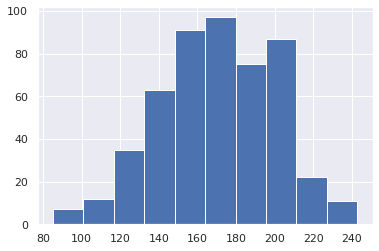

In [19]:
prior_predictive = pm.sample_prior_predictive(model=model)
plt.hist(prior_predictive['alpha'][:,0])